In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 18 8:24:00 2022

@author: Bradley

Code for 2022 MCM/ICM Trading Strategies
"""

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime
import quantstats as qs

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (9,6) #提前设置图片形状大小

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)

In [20]:
gold = pd.read_csv("./raw_data/LBMA-GOLD.csv", names=['date', 'gold'], parse_dates=['date'], index_col='date', skiprows=1)
bitcoin = pd.read_csv("./raw_data/BCHAIN-MKPRU.csv", names=['date', 'bitcoin'], parse_dates=['date'], index_col='date', skiprows=1)

In [21]:
bitcoin.sort_index(inplace=True)
gold.sort_index(inplace=True)
data = pd.merge(bitcoin, gold, on='date', how='outer')

In [22]:
data

,bitcoin,gold
date,,
2016-09-11,621.65,NaN
2016-09-12,609.67,1324.60
2016-09-13,610.92,1323.65
2016-09-14,608.82,1321.75
2016-09-15,610.38,1310.80
...,...,...
2021-09-06,51769.06,1821.60
2021-09-07,52677.40,1802.15
2021-09-08,46809.17,1786.00


#### **大小盘轮动策略**

In [5]:
(data['bitcoin'].pct_change()+1).cumprod().pct_change().mean()

0.0032474778023581026

In [6]:
data['bitcoin'].pct_change().mean()

0.0032351387492408784

In [209]:
def evaluate_investment(source_data, tittle,time='date'):
    temp = source_data.copy()
    # ===新建一个dataframe保存回测指标
    results = pd.DataFrame()

    # ===计算累积净值
    results.loc[0, '累积净值'] = round(temp[tittle].iloc[-1], 2)

    # ===计算年化收益
    annual_return = (temp[tittle].iloc[-1]) ** (
            '1 days 00:00:00' / (temp[time].iloc[-1] - temp[time].iloc[0]) * 365) - 1
    results.loc[0, '年化收益'] = str(round(annual_return * 100, 2)) + '%'

    # ===计算最大回撤
    # 计算当日之前的资金曲线的最高点
    temp['max2here'] = temp[tittle].expanding().max()
    # 计算到历史最高值到当日的跌幅，drowdwon
    temp['dd2here'] = temp[tittle] / temp['max2here'] - 1
    # 计算最大回撤，以及最大回撤结束时间
    end_date, max_draw_down = tuple(temp.sort_values(by=['dd2here']).iloc[0][[time, 'dd2here']])
    # 计算最大回撤开始时间
    start_date = temp[temp[time] <= end_date].sort_values(by=tittle, ascending=False).iloc[0][
        time]
    # 将无关的变量删除
    temp.drop(['max2here', 'dd2here'], axis=1, inplace=True)
    results.loc[0, '最大回撤'] = format(max_draw_down, '.2%')
    results.loc[0, '最大回撤开始时间'] = str(start_date)
    results.loc[0, '最大回撤结束时间'] = str(end_date)

    # ===年化收益/回撤比：我个人比较关注的一个指标
    results.loc[0, '年化收益/回撤比'] = round(annual_return / abs(max_draw_down), 2)
    results.index = ['策略表现']
    return results.T

**轮动优化**

In [122]:
df = data.copy()
# 设置参数
trade_rate1 = 0.0001
trade_rate2 = 0.0002
momentum_days = 20  # 计算多少天的涨跌幅

# 计算两种币每天的涨跌幅pct
df['gold_pct'] = df['gold'].pct_change()
df['bitcoin_pct'] = df['bitcoin'].pct_change()
df.rename(columns={'gold': 'gold_close', 'bitcoin':'bitcoin_close'}, inplace=True)
df.reset_index(inplace=True, drop=False)
df


,date,bitcoin_close,gold_close,gold_pct,bitcoin_pct
0,2016-09-11,621.65,NaN,NaN,NaN
1,2016-09-12,609.67,1324.60,NaN,-0.019271
2,2016-09-13,610.92,1323.65,-0.000717,0.002050
3,2016-09-14,608.82,1321.75,-0.001435,-0.003437
4,2016-09-15,610.38,1310.80,-0.008284,0.002562
...,...,...,...,...,...
1821,2021-09-06,51769.06,1821.60,-0.001152,0.036472
1822,2021-09-07,52677.40,1802.15,-0.010677,0.017546
1823,2021-09-08,46809.17,1786.00,-0.008962,-0.111399
1824,2021-09-09,46078.38,1788.25,0.001260,-0.015612


In [123]:
# 计算N日的涨跌幅momentum
df['gold_mom'] = df['gold_close'].pct_change(periods=momentum_days)
df['bitcoin_mom'] = df['bitcoin_close'].pct_change(periods=momentum_days)



# 轮动条件
df.loc[df['gold_mom'] > df['bitcoin_mom'], 'style'] = 'gold'
df.loc[df['gold_mom'] < df['bitcoin_mom'], 'style'] = 'bitcoin'
df.loc[(df['gold_mom'] < 0) & (df['bitcoin_mom'] < 0), 'style'] = 'empty'

df

,date,bitcoin_close,gold_close,gold_pct,bitcoin_pct,gold_mom,bitcoin_mom,style
0,2016-09-11,621.65,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-09-12,609.67,1324.60,NaN,-0.019271,NaN,NaN,NaN
2,2016-09-13,610.92,1323.65,-0.000717,0.002050,NaN,NaN,NaN
3,2016-09-14,608.82,1321.75,-0.001435,-0.003437,NaN,NaN,NaN
4,2016-09-15,610.38,1310.80,-0.008284,0.002562,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1821,2021-09-06,51769.06,1821.60,-0.001152,0.036472,0.017966,0.125841,bitcoin
1822,2021-09-07,52677.40,1802.15,-0.010677,0.017546,0.010485,0.179823,bitcoin
1823,2021-09-08,46809.17,1786.00,-0.008962,-0.111399,0.002217,0.045364,bitcoin
1824,2021-09-09,46078.38,1788.25,0.001260,-0.015612,0.005171,-0.014042,gold


In [124]:
# 相等时维持原来的仓位。
df['style'].fillna(method='ffill', inplace=True)
# 收盘才能确定风格，实际的持仓pos要晚一天。
df['pos'] = df['style'].shift(1)
# 删除持仓为nan的天数
df.dropna(subset=['pos'], inplace=True)
# 计算策略的整体涨跌幅strategy_pct
df.loc[df['pos'] == 'gold', 'strategy_pct'] = df['gold_pct']
df.loc[df['pos'] == 'bitcoin', 'strategy_pct'] = df['bitcoin_pct']
df.loc[df['pos'] == 'empty', 'strategy_pct'] = 0
df

,date,bitcoin_close,gold_close,gold_pct,bitcoin_pct,gold_mom,bitcoin_mom,style,pos,strategy_pct
22,2016-10-03,611.85,1313.30,-0.006957,-0.001843,-0.007819,0.001522,bitcoin,bitcoin,-0.001843
23,2016-10-04,609.62,1283.30,-0.022843,-0.003645,-0.029090,0.001314,bitcoin,bitcoin,-0.003645
24,2016-10-05,607.18,1269.40,-0.010831,-0.004002,-0.031584,-0.005243,empty,bitcoin,-0.004002
25,2016-10-06,612.08,1254.50,-0.011738,0.008070,-0.041159,0.004876,bitcoin,empty,0.000000
26,2016-10-07,617.21,1258.75,0.003388,0.008381,-0.037910,0.016753,bitcoin,bitcoin,0.008381
...,...,...,...,...,...,...,...,...,...,...
1821,2021-09-06,51769.06,1821.60,-0.001152,0.036472,0.017966,0.125841,bitcoin,bitcoin,0.036472
1822,2021-09-07,52677.40,1802.15,-0.010677,0.017546,0.010485,0.179823,bitcoin,bitcoin,0.017546
1823,2021-09-08,46809.17,1786.00,-0.008962,-0.111399,0.002217,0.045364,bitcoin,bitcoin,-0.111399
1824,2021-09-09,46078.38,1788.25,0.001260,-0.015612,0.005171,-0.014042,gold,bitcoin,-0.015612


In [125]:
df[df['pos']=='gold']

,date,bitcoin_close,gold_close,gold_pct,bitcoin_pct,gold_mom,bitcoin_mom,style,pos,strategy_pct
123,2017-01-12,780.92,1205.05,0.022485,-0.005476,0.065143,-0.133572,gold,gold,0.022485
124,2017-01-13,826.29,1190.35,-0.012199,0.058098,0.052150,-0.073261,gold,gold,-0.012199
125,2017-01-14,817.91,NaN,0.000000,-0.010142,0.052150,-0.083677,gold,gold,0.000000
126,2017-01-15,819.55,NaN,0.000000,0.002005,0.052150,-0.086679,gold,gold,0.000000
127,2017-01-16,830.50,1203.00,0.010627,0.013361,0.063331,-0.107344,gold,gold,0.010627
...,...,...,...,...,...,...,...,...,...,...
1778,2021-07-25,34279.34,NaN,0.000000,0.020777,0.004605,-0.029170,gold,gold,0.000000
1779,2021-07-26,35365.20,1800.20,0.000333,0.031677,-0.005332,0.047921,bitcoin,gold,0.000333
1816,2021-09-01,47155.87,1811.80,-0.001681,0.001723,0.036855,0.033860,gold,gold,-0.001681
1817,2021-09-02,48862.76,1812.55,0.000414,0.036197,0.021817,0.100072,bitcoin,gold,0.000414


In [126]:
# 调仓时间
df.loc[df['pos'] != df['pos'].shift(1), 'trade_time'] = df['date']
# 将调仓日的涨跌幅修正为开盘价买入涨跌幅
df.loc[(df['trade_time'].notnull()) & (df['pos'] == 'coin1'), 'strategy_pct_adjust'] = df['gold_close'] / (
        df['gold_close'] * (1 + trade_rate1)) - 1
df.loc[(df['trade_time'].notnull()) & (df['pos'] == 'coin2'), 'strategy_pct_adjust'] = df['bitcoin_close'] / (
        df['bitcoin_close'] * (1 + trade_rate2)) - 1
df.loc[df['trade_time'].isnull(), 'strategy_pct_adjust'] = df['strategy_pct']

# 扣除卖出手续费
df.loc[(df['trade_time'].shift(-1).notnull()) & (df['pos'] == 'gold'), 'strategy_pct_adjust'] = (1 + df['strategy_pct']) * (1 - trade_rate1) - 1
df.loc[(df['trade_time'].shift(-1).notnull()) & (df['pos'] == 'bitcoin'), 'strategy_pct_adjust'] = (1 + df['strategy_pct']) * (1 - trade_rate2) - 1


# 空仓的日子，涨跌幅用0填充
df['strategy_pct_adjust'].fillna(value=0.0, inplace=True)
del df['strategy_pct'], df['style']

df.reset_index(drop=True, inplace=True)
# 计算净值
df['gold_net'] = df['gold_close'] / df['gold_close'][0]
df['bitcoin_net'] = df['bitcoin_close'] / df['bitcoin_close'][0]
df['strategy_net'] = (1 + df['strategy_pct_adjust']).cumprod()

# 评估策略的好坏
res = evaluate_investment(df, 'strategy_net', time='date')

In [127]:
res

,策略表现
累积净值,10.43
年化收益,60.74%
最大回撤,-60.44%
最大回撤开始时间,2019-06-27 00:00:00
最大回撤结束时间,2020-10-17 00:00:00
年化收益/回撤比,1.0


In [128]:
df = df.set_index('date')

<AxesSubplot:xlabel='date'>

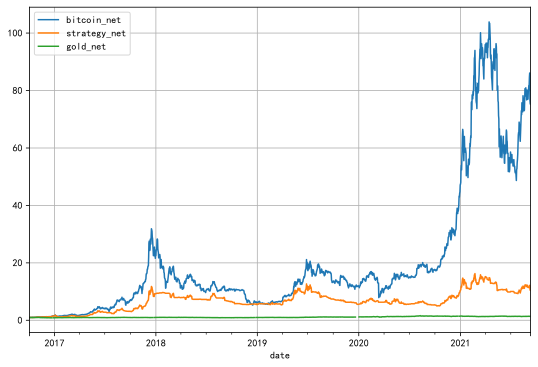

In [129]:
df[['bitcoin_net','strategy_net', 'gold_net']].plot(kind='line', grid=True, figsize=(9,6), legend=True)

In [85]:
df.tail(10)

,date,bitcoin_close,gold_close,gold_pct,bitcoin_pct,gold_mom,bitcoin_mom,pos,trade_time,strategy_pct_adjust,gold_net,bitcoin_net,strategy_net
1794,2021-09-01,47155.87,1811.80,-0.001681,0.001723,0.036855,0.033860,gold,2021-09-01,0.000000,1.379578,77.070965,73.382554
1795,2021-09-02,48862.76,1812.55,0.000414,0.036197,0.021817,0.100072,gold,NaT,-0.002087,1.380149,79.860685,73.229399
1796,2021-09-03,49329.01,1823.70,0.006152,0.009542,0.028103,0.031255,bitcoin,2021-09-03,0.000000,1.388639,80.622718,73.229399
1797,2021-09-04,50035.33,NaN,0.000000,0.014319,0.028103,0.062046,bitcoin,NaT,0.014319,NaN,81.777119,74.277938
1798,2021-09-05,49947.38,NaN,0.000000,-0.001758,0.020909,0.061436,bitcoin,NaT,-0.001758,NaN,81.633374,74.147375
1799,2021-09-06,51769.06,1821.60,-0.001152,0.036472,0.017966,0.125841,bitcoin,NaT,0.036472,1.387040,84.610705,76.851677
1800,2021-09-07,52677.40,1802.15,-0.010677,0.017546,0.010485,0.179823,bitcoin,NaT,0.017546,1.372230,86.095285,78.200116
1801,2021-09-08,46809.17,1786.00,-0.008962,-0.111399,0.002217,0.045364,bitcoin,NaT,-0.111399,1.359933,76.504323,69.488672
1802,2021-09-09,46078.38,1788.25,0.001260,-0.015612,0.005171,-0.014042,bitcoin,NaT,-0.018073,1.361646,75.309929,68.232797
1803,2021-09-10,46368.69,1794.60,0.003551,0.006300,0.008741,-0.059988,gold,2021-09-10,0.000000,1.366481,75.784408,68.232797


完整框架

In [23]:
def evaluate_investment(source_data, tittle,time='date'):
    temp = source_data.copy()
    # ===新建一个dataframe保存回测指标
    results = pd.DataFrame()

    # ===计算累积净值
    results.loc[0, '累积净值'] = round(temp[tittle].iloc[-1], 2)

    # ===计算年化收益
    annual_return = (temp[tittle].iloc[-1]) ** (
            '1 days 00:00:00' / (temp[time].iloc[-1] - temp[time].iloc[0]) * 365) - 1
    results.loc[0, '年化收益'] = str(round(annual_return * 100, 2)) + '%'

    # ===计算最大回撤
    # 计算当日之前的资金曲线的最高点
    temp['max2here'] = temp[tittle].expanding().max()
    # 计算到历史最高值到当日的跌幅，drowdwon
    temp['dd2here'] = temp[tittle] / temp['max2here'] - 1
    # 计算最大回撤，以及最大回撤结束时间
    end_date, max_draw_down = tuple(temp.sort_values(by=['dd2here']).iloc[0][[time, 'dd2here']])
    # 计算最大回撤开始时间
    start_date = temp[temp[time] <= end_date].sort_values(by=tittle, ascending=False).iloc[0][
        time]
    # 将无关的变量删除
    temp.drop(['max2here', 'dd2here'], axis=1, inplace=True)
    results.loc[0, '最大回撤'] = format(max_draw_down, '.2%')
    results.loc[0, '最大回撤开始时间'] = str(start_date)
    results.loc[0, '最大回撤结束时间'] = str(end_date)

    # ===年化收益/回撤比：我个人比较关注的一个指标
    results.loc[0, '年化收益/回撤比'] = round(annual_return / abs(max_draw_down), 2)
    results.index = ['策略表现']
    return results.T

In [24]:
data['gold'].notnull()

date
2016-09-11    False
2016-09-12     True
2016-09-13     True
2016-09-14     True
2016-09-15     True
              ...  
2021-09-06     True
2021-09-07     True
2021-09-08     True
2021-09-09     True
2021-09-10     True
Name: gold, Length: 1826, dtype: bool

In [25]:
np.isnan(data['gold'][0]) == False

False

In [26]:
def rotation_strategy(df, trade_rate1, trade_rate2, momentum_days):
        # return calculation
        df['gold_pct'] = df['gold'].pct_change()
        df['bitcoin_pct'] = df['bitcoin'].pct_change()
        df.rename(columns={'gold': 'gold_close', 'bitcoin':'bitcoin_close'}, inplace=True)
        df.reset_index(inplace=True, drop=False)

        # momentum calculation
        df['gold_mom'] = df['gold_close'].pct_change(periods=momentum_days)
        df['bitcoin_mom'] = df['bitcoin_close'].pct_change(periods=momentum_days)

        # rotation principle
        # gold can only be traded during trading days
        df.loc[(df['gold_mom'] > df['bitcoin_mom']) & (df['gold_close'].notnull()), 'style'] = 'gold'
        df.loc[df['gold_mom'] < df['bitcoin_mom'], 'style'] = 'bitcoin'
        df.loc[(df['gold_mom'] < 0) & (df['bitcoin_mom'] < 0), 'style'] = 'empty'


        # maintain the same position
        df['style'].fillna(method='ffill', inplace=True)

        


        # position can only be changed in the next day
        df['pos'] = df['style'].shift(1)
        # 删除持仓为nan的天数
        df.dropna(subset=['pos'], inplace=True)
        # 计算策略的整体涨跌幅strategy_pct
        df.loc[df['pos'] == 'gold', 'strategy_pct'] = df['gold_pct']
        df.loc[df['pos'] == 'bitcoin', 'strategy_pct'] = df['bitcoin_pct']
        df.loc[df['pos'] == 'empty', 'strategy_pct'] = 0


        # 调仓时间
        df.loc[df['pos'] != df['pos'].shift(1), 'trade_time'] = df['date']
        # 将调仓日的涨跌幅修正为开盘价买入涨跌幅
        df.loc[(df['trade_time'].notnull()) & (df['pos'] == 'gold'), 'strategy_pct_adjust'] = df['gold_close'] / (
                df['gold_close'] * (1 + trade_rate1)) - 1
        df.loc[(df['trade_time'].notnull()) & (df['pos'] == 'bitcoin'), 'strategy_pct_adjust'] = df['bitcoin_close'] / (
                df['bitcoin_close'] * (1 + trade_rate2)) - 1
        df.loc[df['trade_time'].isnull(), 'strategy_pct_adjust'] = df['strategy_pct']

        # 扣除卖出手续费
        df.loc[(df['trade_time'].shift(-1).notnull()) & (df['pos'] == 'gold'), 'strategy_pct_adjust'] = (1 + df['strategy_pct']) * (1 - trade_rate1) - 1
        df.loc[(df['trade_time'].shift(-1).notnull()) & (df['pos'] == 'bitcoin'), 'strategy_pct_adjust'] = (1 + df['strategy_pct']) * (1 - trade_rate2) - 1


        # 空仓的日子，涨跌幅用0填充
        df['strategy_pct_adjust'].fillna(value=0.0, inplace=True)
        del df['strategy_pct'], df['style']

        df.reset_index(drop=True, inplace=True)
        # 计算净值
        df['gold_net'] = df['gold_close'] / df['gold_close'][0]
        df['bitcoin_net'] = df['bitcoin_close'] / df['bitcoin_close'][0]
        df['strategy_net'] = (1 + df['strategy_pct_adjust']).cumprod()

        # 评估策略的好坏
        res = evaluate_investment(df, 'strategy_net', time='date')
        return res, df


In [27]:
performance = pd.DataFrame()
for momentum_days in range(10, 100, 2):
    res, df = rotation_strategy(data.copy(), trade_rate1=1e-4,trade_rate2=2e-4, momentum_days=momentum_days)
    performance.loc[str(momentum_days), 'strat_return'] = res['策略表现'][0]
    performance.loc[str(momentum_days), 'annual_return'] = res['策略表现'][1]
    performance.loc[str(momentum_days), 'max_drawdown'] = res['策略表现'][2]
    performance.loc[str(momentum_days), 'drawdown_begin'] = res['策略表现'][3]
    performance.loc[str(momentum_days), 'drawdown_end'] = res['策略表现'][4]
    performance.loc[str(momentum_days), 'return/drawdown'] = res['策略表现'][5]

In [28]:
performance.index.name = 'parameter'
performance = performance.sort_values(by='return/drawdown', ascending=False)
performance

,strat_return,annual_return,max_drawdown,drawdown_begin,drawdown_end,return/drawdown
parameter,,,,,,
20,111.53,159.7%,-36.33%,2019-06-27 00:00:00,2019-12-26 00:00:00,4.40
18,102.90,155.24%,-43.22%,2021-02-22 00:00:00,2021-07-26 00:00:00,3.59
14,135.99,169.45%,-49.19%,2017-12-16 00:00:00,2019-02-15 00:00:00,3.44
10,60.87,128.68%,-49.42%,2017-12-16 00:00:00,2019-02-15 00:00:00,2.60
60,95.86,157.19%,-64.51%,2017-12-16 00:00:00,2019-03-07 00:00:00,2.44
32,95.30,153.12%,-67.22%,2017-12-16 00:00:00,2019-01-23 00:00:00,2.28
80,87.56,155.11%,-69.55%,2017-12-16 00:00:00,2018-11-13 00:00:00,2.23
96,68.93,144.65%,-65.86%,2017-12-16 00:00:00,2018-02-12 00:00:00,2.20
94,68.08,143.76%,-65.86%,2017-12-16 00:00:00,2018-02-12 00:00:00,2.18


In [29]:
performance.index[0]

'20'

In [30]:
res, df = rotation_strategy(data.copy(), trade_rate1=1e-4,trade_rate2=2e-4, momentum_days=int(performance.index[0]))
res

,策略表现
累积净值,111.53
年化收益,159.7%
最大回撤,-36.33%
最大回撤开始时间,2019-06-27 00:00:00
最大回撤结束时间,2019-12-26 00:00:00
年化收益/回撤比,4.4


In [32]:
df.set_index('date', inplace=True)

<AxesSubplot:xlabel='date'>

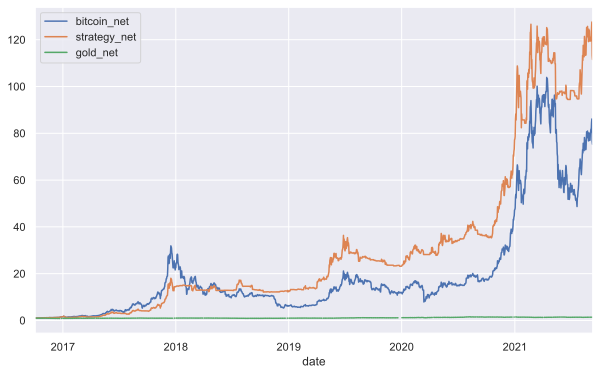

In [33]:
sns.set_theme()
(df[['bitcoin_net','strategy_net', 'gold_net']]).plot(kind='line', grid=True, figsize=(10,6), legend=True)
plt.savefig('./images/rotation.png', dpi=1500)

In [341]:
df.tail(10)

,bitcoin_close,gold_close,gold_pct,bitcoin_pct,gold_mom,bitcoin_mom,pos,trade_time,strategy_pct_adjust,gold_net,bitcoin_net,strategy_net
date,,,,,,,,,,,,
2021-09-01,47155.87,1811.80,-0.001681,0.001723,0.036855,0.033860,gold,2021-09-01,-0.000100,1.379578,77.070965,119.425270
2021-09-02,48862.76,1812.55,0.000414,0.036197,0.021817,0.100072,gold,NaT,0.000314,1.380149,79.860685,119.462759
2021-09-03,49329.01,1823.70,0.006152,0.009542,0.028103,0.031255,bitcoin,2021-09-03,-0.000200,1.388639,80.622718,119.438871
2021-09-04,50035.33,NaN,0.000000,0.014319,0.028103,0.062046,bitcoin,NaT,0.014319,NaN,81.777119,121.149063
2021-09-05,49947.38,NaN,0.000000,-0.001758,0.020909,0.061436,bitcoin,NaT,-0.001758,NaN,81.633374,120.936112
2021-09-06,51769.06,1821.60,-0.001152,0.036472,0.017966,0.125841,bitcoin,NaT,0.036472,1.387040,84.610705,125.346892
2021-09-07,52677.40,1802.15,-0.010677,0.017546,0.010485,0.179823,bitcoin,NaT,0.017546,1.372230,86.095285,127.546229
2021-09-08,46809.17,1786.00,-0.008962,-0.111399,0.002217,0.045364,bitcoin,NaT,-0.111399,1.359933,76.504323,113.337657
2021-09-09,46078.38,1788.25,0.001260,-0.015612,0.005171,-0.014042,bitcoin,NaT,-0.015809,1.361646,75.309929,111.545904


In [342]:
df.to_csv("./result/rotation.csv", index=True, header=True)

In [343]:
qs.reports.html(df['strategy_net'], benchmark=df['bitcoin_net'], output="rotation.html")

In [344]:
qs.reports.html(df['strategy_net'], benchmark=df['gold_net'], output="rotation.html")

In [350]:
data

,bitcoin,gold
date,,
2016-09-11,621.65,NaN
2016-09-12,609.67,1324.60
2016-09-13,610.92,1323.65
2016-09-14,608.82,1321.75
2016-09-15,610.38,1310.80
...,...,...
2021-09-06,51769.06,1821.60
2021-09-07,52677.40,1802.15
2021-09-08,46809.17,1786.00


In [351]:
df

,bitcoin_close,gold_close,gold_pct,bitcoin_pct,gold_mom,bitcoin_mom,pos,trade_time,strategy_pct_adjust,gold_net,bitcoin_net,strategy_net
date,,,,,,,,,,,,
2016-10-03,611.85,1313.30,-0.006957,-0.001843,-0.007819,0.001522,bitcoin,2016-10-03,-0.000200,1.000000,1.000000,0.999800
2016-10-04,609.62,1283.30,-0.022843,-0.003645,-0.029090,0.001314,bitcoin,NaT,-0.003645,0.977157,0.996355,0.996156
2016-10-05,607.18,1269.40,-0.010831,-0.004002,-0.031584,-0.005243,bitcoin,NaT,-0.004202,0.966573,0.992367,0.991971
2016-10-06,612.08,1254.50,-0.011738,0.008070,-0.041159,0.004876,empty,2016-10-06,0.000000,0.955227,1.000376,0.991971
2016-10-07,617.21,1258.75,0.003388,0.008381,-0.037910,0.016753,bitcoin,2016-10-07,-0.000200,0.958463,1.008760,0.991772
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-06,51769.06,1821.60,-0.001152,0.036472,0.017966,0.125841,bitcoin,NaT,0.036472,1.387040,84.610705,125.346892
2021-09-07,52677.40,1802.15,-0.010677,0.017546,0.010485,0.179823,bitcoin,NaT,0.017546,1.372230,86.095285,127.546229
2021-09-08,46809.17,1786.00,-0.008962,-0.111399,0.002217,0.045364,bitcoin,NaT,-0.111399,1.359933,76.504323,113.337657


In [354]:
def max_drawdown(X):
    X = np.array(X)
    try:
        i = np.argmax((np.maximum.accumulate(X) - X)/np.maximum.accumulate(X))
        j = np.argmax(X[:i])
        return -(X[j]-X[i])/X[j], i, j
    except:
        return 0
max_drawdown(df['strategy_net'])

(-0.36325322759757095, 1179, 997)

In [356]:
df.index[1179]
df.index[997]


Timestamp('2019-12-26 00:00:00')

Timestamp('2019-06-27 00:00:00')

In [372]:
df.index[0].date

<function Timestamp.date>

In [362]:
(df.index[0]).strftime('%Y-%m-%d')

'2016-10-03'

In [363]:
import tushare as ts
ts.set_token("0d86b9a1aa5a9ba78b7e3a2feba63242abaeae62c777f5742f6cf698")
pro = ts.pro_api()

def get_return(code):
    df=ts.get_k_data(code,start='2010-01-01')
    df.index=pd.to_datetime(df.date)
    return df.close.pct_change().fillna(0).tz_localize('UTC')
ret=get_return('600519')
benchmark_ret=get_return('sh')
#假设前面是模拟盘，2017年开始实盘买入600519并一直持有
date='2017-01-03' #实盘开始日期

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [366]:
ret.index

DatetimeIndex(['2010-01-04 00:00:00+00:00', '2010-01-05 00:00:00+00:00', '2010-01-06 00:00:00+00:00', '2010-01-07 00:00:00+00:00', '2010-01-08 00:00:00+00:00',
               '2010-01-11 00:00:00+00:00', '2010-01-12 00:00:00+00:00', '2010-01-13 00:00:00+00:00', '2010-01-14 00:00:00+00:00', '2010-01-15 00:00:00+00:00',
               ...
               '2022-02-07 00:00:00+00:00', '2022-02-08 00:00:00+00:00', '2022-02-09 00:00:00+00:00', '2022-02-10 00:00:00+00:00', '2022-02-11 00:00:00+00:00',
               '2022-02-14 00:00:00+00:00', '2022-02-15 00:00:00+00:00', '2022-02-16 00:00:00+00:00', '2022-02-17 00:00:00+00:00', '2022-02-18 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=2940, freq=None)

In [365]:
benchmark_ret

date
2010-01-04 00:00:00+00:00    0.000000
2010-01-05 00:00:00+00:00    0.011844
2010-01-06 00:00:00+00:00   -0.008520
2010-01-07 00:00:00+00:00   -0.018880
2010-01-08 00:00:00+00:00    0.001009
                               ...   
2022-02-14 00:00:00+00:00   -0.009838
2022-02-15 00:00:00+00:00    0.005019
2022-02-16 00:00:00+00:00    0.005728
2022-02-17 00:00:00+00:00    0.000638
2022-02-18 00:00:00+00:00    0.006551
Name: close, Length: 2946, dtype: float64